In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import atecml.data
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

class BasicModel(object):
    """Parent class of basic models"""
    def train(self, x_train, y_train, x_val, y_val):
        """return a trained model and eval metric o validation data"""
        pass
    
    def predict(self, model, x_test):
        """return the predicted result"""
        pass
    
    def get_oof(self, x_train, y_train, x_test, n_folds = 5):
        """K-fold stacking"""
        num_train, num_test = x_train.shape[0], x_test.shape[0]
        oof_train = np.zeros((num_train,)) 
        oof_test = np.zeros((num_test,))
        oof_test_all_fold = np.zeros((num_test, n_folds))
        aucs = []
        model_list = []
        
        for i in range(0,n_folds):
            
            val_index = DateFold[5] #始终用最后20%验证            
            train_index = list(all_list - DateFold[i])
                            
            print('{0} fold, train {1}, val {2}'.format(i, len(train_index), len(val_index)))
            x_tra, y_tra = x_train[train_index], y_train[train_index]
            x_val, y_val = x_train[val_index], y_train[val_index]
            
            #Over_sample
            X_resampled, y_resampled = SMOTE().fit_sample(x_tra,y_tra)
            model, auc = self.train(X_resampled, y_resampled, x_val, y_val)
            #model, auc = self.train(x_tra, y_tra, x_val, y_val)
            aucs.append(auc)
            model_list.append(model)
            oof_train[val_index] = self.predict(model, x_val)
            oof_test_all_fold[:, i] = self.predict(model, x_test)
        oof_test = np.mean(oof_test_all_fold, axis=1)
        print('all aucs {0}, average {1}'.format(aucs, np.mean(aucs)))
        return oof_train, oof_test,model_list

import lightgbm as lgb
class LGBClassifier(BasicModel):
    '''
    ' 调参范围
    'num_leaves':range(35,65,5)
    'learning_rate':[0.01,0.05,0.1,0.3,0.5,0.7]
    'min_child_weight':range(1,6,2)
    'max_depth':range(3,10,2),
    'subsample':[i/10.0 for i in range(6,10)],正常直接设置为1
    'colsample_bytree':[i/10.0 for i in range(6,10)]，正常直接设置为1
    'reg_alpha','reg_lambda':[1e-5, 1e-2, 0.1, 1, 2,2.5,3]
    '''
    def __init__(self,boost_type,boost_round=1000,early_stop=100,pos_weight=1):
        self.num_boost_round = boost_round
        self.early_stopping_rounds = early_stop
        self.params = {
            'task': 'train',
            'boosting_type': boost_type,
            'objective': 'binary',            
            'nthread': 40,            
            'metric': {'auc'},
            'max_depth': 6,            
            'num_leaves': 50,
            #'reg_alpha': 0.01,
            #'reg_lambda': 0.01,
            #'is_unbalance':'true',
            'scale_pos_weight': pos_weight,
            'use_missing': 'true',
            'verbose' : -1,
            #'device': 'gpu'
            }
        print(self.params)
        
    def train(self, x_train, y_train, x_val, y_val):
        print('train with lgb model')
        lgbtrain = lgb.Dataset(x_train, y_train)
        lgbval = lgb.Dataset(x_val, y_val)
        model = lgb.train(self.params, 
                          lgbtrain,
                          valid_sets=lgbval, 
                          verbose_eval = 50,
                          num_boost_round = self.num_boost_round,
                          early_stopping_rounds = self.early_stopping_rounds)
        return model, model.best_score['valid_0']['auc']
    
    def predict(self, model, x_test):
        print('test with lgb model')
        return model.predict(x_test, num_iteration=model.best_iteration)



In [2]:
train_df = pd.read_pickle('./01_train.dat')
val_df =  pd.read_pickle('./01_test.dat')

#train_df = atecml.data.load_train()
#val_df = atecml.data.load_test()
train_df.loc[train_df.label == 0, 'Fraud'] = 0
train_df.loc[train_df.label != 0, 'Fraud'] = 1



In [21]:
#predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_SUM]
import joblib
predictors = joblib.load('./woe_feature.dat')
predictors = ['n_f20',
 'n_f198',
 'n_f26',
 'n_f281',
 'n_f268',
 'n_f21',
 'n_f185',
 'n_f270',
 'n_f271',
 'n_f260',
 'n_f77',
 'n_f235',
 'n_f192',
 'n_f53',
 'n_f259',
 'n_f210',
 'n_NaN_LIST',
 'n_f76',
 'n_f244',
 'n_f31',
 'n_f274',
 'n_f28',
 'n_f209',
 'n_f202',
 'n_f29',
 'n_f261',
 'n_f95',
 'n_f264',
 'n_f203',
 'n_f206',
 'n_f288',
 'n_f30',
 'n_f216',
 'n_f204',
 'n_f292',
 'n_f25',
 'n_f277',
 'n_f265',
 'n_f55',
 'n_f182',
 'n_f52',
 'n_f197',
 'n_f178',
 'n_f258',
 'n_f237',
 'n_f78',
 'n_f279',
 'n_f269',
 'n_f234',
 'n_f7',
 'n_f263',
 'n_f193',
 'n_f24',
 'n_f184',
 'n_f54',
 'n_f262',
 'n_f171',
 'n_f278',
 'n_f215',
 'n_f208',
 'n_f183',
 'n_f5',
 'n_f236',
 'n_f12',
 'n_f191',
 'n_f257',
 'n_f205',
 'n_f96',
 'n_f97',
 'n_f190',
 'n_f275',
 'n_f6',
 'n_f79',
 'n_f276',
 'n_f280',
 'n_f266']


DateFold={}

DateFold[0] = set(atecml.data.filter_date(train_df,start_date='2017-09-05',end_date='2017-09-12').index)
DateFold[1] = set(atecml.data.filter_date(train_df,start_date='2017-09-13',end_date='2017-09-20').index)
DateFold[2] = set(atecml.data.filter_date(train_df,start_date='2017-09-21',end_date='2017-09-28').index)
DateFold[3] = set(atecml.data.filter_date(train_df,start_date='2017-09-29',end_date='2017-10-06').index)
DateFold[4] = set(atecml.data.filter_date(train_df,start_date='2017-10-07',end_date='2017-10-14').index)
DateFold[5] = list(atecml.data.filter_date(train_df,start_date='2017-10-15',end_date='2017-11-24').index)

all_list = set(train_df.index) - set(DateFold[5])
len(all_list),len(DateFold[5])

(634284, 360447)

In [22]:
target='Fraud'
x_train = np.array(train_df[predictors])
y_train = np.array(train_df[target])
x_test = np.array(val_df[predictors])
print(x_train.shape, y_train.shape, x_test.shape)

(994731, 76) (994731,) (500538, 76)


In [23]:
num_pos = np.sum(train_df[target])  
num_neg = x_train.shape[0]- num_pos
scale_pos_weight = num_neg/ num_pos
print(num_pos,num_neg,scale_pos_weight)

16847.0 977884.0 58.04499317385885


In [24]:
num_boost_round = 5000
num_early_stop = 100

In [25]:
dart_classifier = LGBClassifier(boost_type='dart',boost_round=num_boost_round,early_stop=num_early_stop,pos_weight= scale_pos_weight)
dart_oof_train, dart_oof_test,dart_model_list = dart_classifier.get_oof(x_train, y_train, x_test)
print(dart_oof_train.shape, dart_oof_test.shape)    

gbdt_classifier = LGBClassifier(boost_type='gbdt',boost_round=num_boost_round,early_stop=num_early_stop,pos_weight= scale_pos_weight)
gbdt_oof_train, gbdt_oof_test,gbdt_model_list = gbdt_classifier.get_oof(x_train, y_train, x_test)
print(gbdt_oof_train.shape, gbdt_oof_test.shape)  

{'nthread': 40, 'objective': 'binary', 'task': 'train', 'scale_pos_weight': 58.04499317385885, 'boosting_type': 'dart', 'num_leaves': 50, 'use_missing': 'true', 'metric': {'auc'}, 'verbose': -1, 'max_depth': 6}
0 fold, train 500685, val 360447
train with lgb model
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.94858
[100]	valid_0's auc: 0.9555
[150]	valid_0's auc: 0.960917
[200]	valid_0's auc: 0.960478
[250]	valid_0's auc: 0.960675
Early stopping, best iteration is:
[186]	valid_0's auc: 0.961471
test with lgb model
test with lgb model
1 fold, train 509423, val 360447
train with lgb model
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.950736
[100]	valid_0's auc: 0.95636
[150]	valid_0's auc: 0.958816
[200]	valid_0's auc: 0.960439
[250]	valid_0's auc: 0.960971
[300]	valid_0's auc: 0.960616
Early stopping, best iteration is:
[244]	valid_0's auc: 0.961583
test with lgb model
test with lgb model
2 fold, train 509014,

Ant-Score: 0.15927123126652953


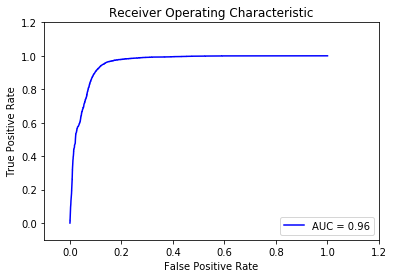

In [26]:
train_dart_r = dart_oof_train
n = int(dart_oof_train.shape[0] * 0.8)
y_pred, y_val = train_dart_r[n:], y_train[n:]
_f1,_f2,_f3 = atecml.data.accuracy_validation(y_val,y_pred)


Ant-Score: 0.20240963855421684


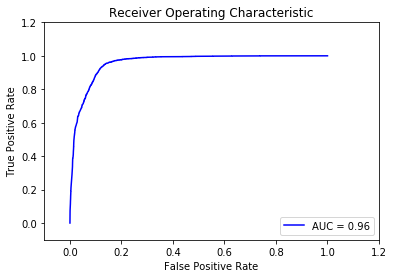

In [27]:
train_dart_r = gbdt_oof_train
n = int(gbdt_oof_train.shape[0] * 0.8)
y_pred, y_val = train_dart_r[n:], y_train[n:]
_f1,_f2,_f3 = atecml.data.accuracy_validation(y_val,y_pred)
